In [4]:
"""
Dedalus script solving the 2D Poisson equation with mixed boundary conditions.
This script demonstrates solving a 2D Cartesian linear boundary value problem
and produces a plot of the solution. It should take just a few seconds to run.

We use a Fourier(x) * Chebyshev(y) discretization to solve the LBVP:
    dx(dx(u)) + dy(dy(u)) = f
    u(y=0) = g
    dy(u)(y=Ly) = h

For a scalar Laplacian on a finite interval, we need two tau terms. Here we
choose to lift them to the natural output (second derivative) basis.

To run and plot:
    $ python3 poisson.py
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Parameters
Lx, Ly = 2*np.pi, np.pi
Nx, Ny = 256, 128
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx))
ybasis = d3.Chebyshev(coords['y'], size=Ny, bounds=(0, Ly))

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Forcing
x, y = dist.local_grids(xbasis, ybasis)
f = dist.Field(bases=(xbasis, ybasis))
g = dist.Field(bases=xbasis)
h = dist.Field(bases=xbasis)
f.fill_random('g', seed=40)
f.low_pass_filter(shape=(64, 32))
g['g'] = np.sin(8*x) * 0.025
h['g'] = 0

# Substitutions
dy = lambda A: d3.Differentiate(A, coords['y'])
lift_basis = ybasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)

# Problem
problem = d3.LBVP([u, tau_1, tau_2], namespace=locals())
problem.add_equation("div(u) + lift(tau_1,-1) + lift(tau_2,-2) = f")
problem.add_equation("u(y=0) = g")
problem.add_equation("dy(u)(y=Ly) = h")

# Solver
solver = problem.build_solver()
solver.solve()

# Gather global data
x = xbasis.global_grid()
y = ybasis.global_grid()
ug = u.allgather_data('g')

# Plot
if dist.comm.rank == 0:
    plt.figure(figsize=(6, 4))
    plt.pcolormesh(x.ravel(), y.ravel(), ug.T, cmap='viridis', shading='gouraud', rasterized=True)
    plt.gca().set_aspect('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Randomly forced Poisson equation")
    plt.tight_layout()
    plt.savefig('poisson.pdf')
    plt.savefig('poisson.png', dpi=200)


KeyboardInterrupt: 

2023-08-03 16:41:43,693 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s


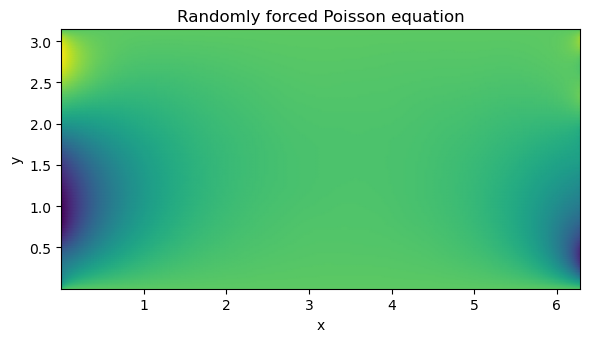

In [2]:
"""
Dedalus script solving the 2D Poisson equation with mixed boundary conditions.
This script demonstrates solving a 2D Cartesian linear boundary value problem
and produces a plot of the solution. It should take just a few seconds to run.

We use a Fourier(x) * Chebyshev(y) discretization to solve the LBVP:
    dx(dx(u)) + dy(dy(u)) = f
    u(y=0) = g
    dy(u)(y=Ly) = h

For a scalar Laplacian on a finite interval, we need two tau terms. Here we
choose to lift them to the natural output (second derivative) basis.

To run and plot:
    $ python3 poisson.py
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Parameters
Lx, Ly = 2*np.pi, np.pi
Nx, Ny = 256, 128
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.Chebyshev(coords['x'], size=Nx, bounds=(0, Lx))
ybasis = d3.Chebyshev(coords['y'], size=Ny, bounds=(0, Ly))

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Forcing
x, y = dist.local_grids(xbasis, ybasis)
f = dist.Field(bases=(xbasis, ybasis))
g = dist.Field(bases=xbasis)
h = dist.Field(bases=ybasis)
f.fill_random('g', seed=40)
f.low_pass_filter(shape=(64, 32))
g['g'] = 0
h['g'] = 0

# Substitutions
dy = lambda A: d3.Differentiate(A, coords['y'])
lift_basis = ybasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)

# Problem
problem = d3.LBVP([u, tau_1, tau_2], namespace=locals())
problem.add_equation("lap(u) + lift(tau_1,-1) + lift(tau_2,-2) = f")
problem.add_equation("u(y=0) = g")
problem.add_equation("u(y=Ly) = g")

# Solver
solver = problem.build_solver()
solver.solve()

# Gather global data
x = xbasis.global_grid()
y = ybasis.global_grid()
ug = u.allgather_data('g')

# Plot
if dist.comm.rank == 0:
    plt.figure(figsize=(6, 4))
    plt.pcolormesh(x.ravel(), y.ravel(), ug.T, cmap='viridis', shading='gouraud', rasterized=True)
    plt.gca().set_aspect('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Randomly forced Poisson equation")
    plt.tight_layout()
    plt.savefig('poisson.pdf')
    plt.savefig('poisson.png', dpi=200)


2023-08-04 10:34:20,646 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 15s, Remaining: 0s, Rate: 6.8e-02/s


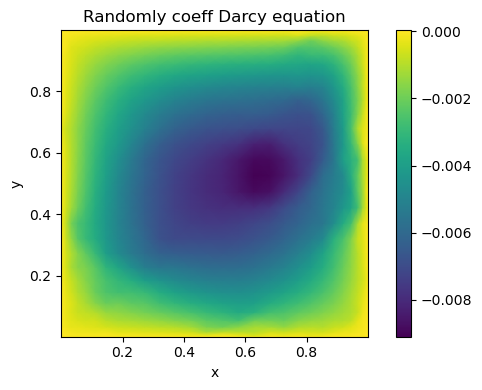

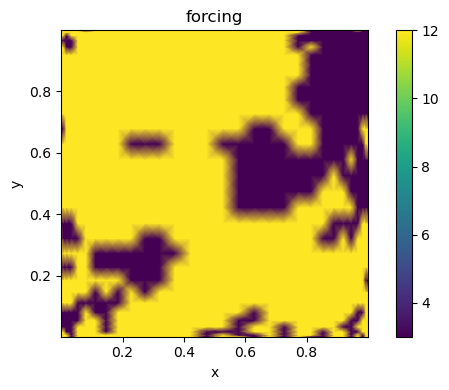

In [38]:

# Parameters
Lx, Ly = 1.0, 1.0
Nx, Ny = 30, 30
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.Chebyshev(coords['x'], size=Nx, bounds=(0, Lx))
ybasis = d3.Chebyshev(coords['y'], size=Ny, bounds=(0, Ly))

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)
tau_3 = dist.Field(name='tau_3', bases=ybasis)
tau_4 = dist.Field(name='tau_4', bases=ybasis)

#np.random.seed(1)
gaussian_coeffs=np.random.normal(size=(100,100))
k = np.linspace(
        1, 1 + gaussian_coeffs.shape[0] - 1, gaussian_coeffs.shape[0]
    )

# Forcing
x, y = dist.local_grids(xbasis, ybasis)
f = dist.Field(bases=(xbasis, ybasis))
g = dist.Field(bases=xbasis)
h = dist.Field(bases=ybasis)

f['g']=np.where(np.sum((np.sin(np.pi * k[None,None, :,None] * x[:,:,None,None])*np.sin(np.pi * k[None,None,None,:] * y[:,:,None,None])) * gaussian_coeffs[None,None,:,:]/ np.pi**2 / (k[None, :] ** 2 + k[:, None] ** 2)[None,None,:,:], axis=(-1, -2)) >= 0, 12, 3)
#f['g']=np.sum(np.sin(np.pi * k[None, :] * x)[:,:,None]*(np.sin(np.pi * k[:,None] * y).T)[:,None,:] * gaussian_coeffs/ np.pi**2 / (k[None, :] ** 2 + k[:, None] ** 2), axis=(1, 2))
#f['g']=np.sum((np.sin(np.pi * k[None,None, :,None] * x[:,:,None,None])*np.sin(np.pi * k[None,None,None,:] * y[:,:,None,None])) * gaussian_coeffs[None,None,:,:]/ np.pi**2 / (k[None, :] ** 2 + k[:, None] ** 2)[None,None,:,:], axis=(-1, -2))
#f['g']=np.sum((np.sin(np.pi * k[:,None] * y).T)[:,None,:]* gaussian_coeffs/ np.pi**2 / (k[None, :] ** 2 + k[:, None] ** 2), axis=(1, 2))
g['g'] = 0
h['g'] = 0

# Substitutions
lift_basis = ybasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)
lift_basis_x = xbasis.derivative_basis(2)
liftx = lambda A, n: d3.Lift(A, lift_basis_x, n)

# Problem
problem = d3.LBVP([u, tau_1, tau_2,tau_3,tau_4], namespace=locals())
problem.add_equation("div(f*grad(u)) + lift(tau_1,-1) + lift(tau_2,-2) + liftx(tau_3,-1) + liftx(tau_4,-2)= 1")
problem.add_equation("u(y=0) = g")
problem.add_equation("u(y=Ly) = g")
problem.add_equation("u(x=0) = h")
problem.add_equation("u(x=Lx) = h")

# Solver
solver = problem.build_solver()
solver.solve()

# Gather global data
x = xbasis.global_grid()
y = ybasis.global_grid()
ug = u.allgather_data('g')

# Plot
if dist.comm.rank == 0:
    plt.figure(figsize=(6, 4))
    plt.pcolormesh(x.ravel(), y.ravel(), ug.T, cmap='viridis', shading='gouraud', rasterized=True)
    plt.colorbar()
    plt.gca().set_aspect('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Randomly coeff Darcy equation")
    plt.tight_layout()
    plt.savefig(f'darcy{np.random.rand()}.png', dpi=200)

    plt.figure(figsize=(6, 4))
    plt.pcolormesh(x.ravel(), y.ravel(), f.allgather_data('g').T, cmap='viridis', shading='gouraud', rasterized=True)
    plt.colorbar()
    plt.gca().set_aspect('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("forcing")
    plt.tight_layout()
    plt.savefig(f'forcing{np.random.rand()}.png', dpi=200)

In [15]:
x.shape

(20, 1)